![人工智慧 - 自由團隊](https://raw.githubusercontent.com/chenkenanalytic/img/master/af/aifreeteam.png)

這篇文章主要是與資料科學初心者們，分享機器學習的基本分析流程，透過 Kaggle 上鐵達尼號生存預測比賽，手把手從**探索性數據分析(Exploratory Data Analysis)**認識資料，到**特徵工程(Feature Engineering)**處理欄位的缺漏值、離群值等，最後，我們建立一個隨機森林(Random Forest)模型來預測資料。   
本文章的用意，除期許能讓機器學習的初心者們有基礎概念外，同時提供幾個分析時常使用的 python 程式碼，讓初心者們能夠更快速上手實作，若已有一定基礎的讀者們，則可再結合 Kaggle 討論區中的文章，更深入來優化整個分析過程。

分析主題：
[Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic)

<center>(Author: Dr. Wu - 彥霖 博士；Editor: Ken；Date of published: 2019/12/3；AI . FREE Team Website: https://aifreeblog.herokuapp.com/)</center>

起手式，我們先載入分析過程中所需要用到的套件：

In [1]:
#pip install sklearn
import pandas as pd
import numpy as np

# 繪圖相關套件
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.style.use( 'ggplot' )

# 標籤編碼(Label)、獨熱編碼(OneHot)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# 決策樹(Decision Tree)
from sklearn.tree import DecisionTreeClassifier
# 隨機森林(Random Forest)
from sklearn.ensemble import RandomForestClassifier

from IPython.display import display
import warnings
warnings.filterwarnings( 'ignore' )

##上傳資料
透過 Kaggle 資料競賽網站，下載鐵達尼號資料集。(Link: https://www.kaggle.com/c/titanic/data)

(點擊 "Download All" 後解壓縮，並透過下方程式碼上傳
gender_submission.csv, test.csv
, train.csv 三份檔案)

※ 可一次上傳或分批上傳，上傳成功後，點擊左方 "Files" 欄位，即可看到上傳的檔案。 ※

In [5]:
from google.colab import files

uploaded = files.upload()

Saving gender_submission.csv to gender_submission.csv


## 匯入資料

透過 pandas 匯入訓練集與測試集資料，並利用 shape 得知資料的維度：  
* 訓練集有 891 筆資料、12 個特徵欄位；
* 測試集有 418 筆資料、11 個特徵欄位；   
其中，訓練集較測試集多了判別乘客罹難或生還的特徵欄位 Survived，0 表示罹難者，1 表示生還者。

In [6]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
submit = pd.read_csv('gender_submission.csv')

print( f'train {df_train.shape}' )
display( df_train.head() )

print( f'\ntest {df_test.shape}' )
display( df_test.head() )

train (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



test (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 欄位型態(Column Types)

我們透過自定義的函數 Col_Types，觀察訓練集與測試集共同的特徵欄位型態，數值型態的特徵欄位有 6 欄，非數值型態的特徵欄位有 5 欄，另外，Survived 欄位為數值型態。

In [7]:
# 定義判別欄位型態的函數
def Col_Types( Data ):
    Column_Types = Data.dtypes.to_frame().reset_index()   # 判別每個欄位的型態
    Column_Types.columns = ['ColumnName','Type']
    Column_Types.sort_values( by='Type', inplace=True )
    return Column_Types

In [8]:
display( Col_Types(df_train) )

,ColumnName,Type
0,PassengerId,int64
1,Survived,int64
2,Pclass,int64
6,SibSp,int64
7,Parch,int64
5,Age,float64
9,Fare,float64
3,Name,object
4,Sex,object
8,Ticket,object


## 缺漏值(Missing Values)  
在分析資料之前，我們還需先檢視資料是否存有缺漏值(Missing Values)，如果欄位存有缺漏值，之後在特徵工程(Feature Engineering)的過程中，我們可視欄位中缺漏值的比例或對預測值的相關性，決定填補或排除此欄位的處理方法。   
透過我們自定義的函數 Missing_Counts ，發現 Embarked、Fare、Cabin、Age 欄位有缺漏值，當中， Cabin 欄位的缺漏情況最為嚴重，訓練集中約有 77%、測試集中約有 78% 的缺漏值，其次為 Age 欄位，訓練集中約有 20%、測試集中約有 21% 的缺漏值。

In [9]:
# 定義用來統計欄位缺漏值總數的函數
def Missing_Counts( Data ) :
    missing = Data.isnull().sum()  # 計算欄位中缺漏值的數量
    missing = missing[ missing>0 ]
    missing.sort_values( inplace=True )

    Missing_Count = pd.DataFrame( { 'ColumnName':missing.index, 'MissingCount':missing.values } )  # Convert Series to DataFrame
    Missing_Count[ 'Percentage(%)' ] = Missing_Count['MissingCount'].apply( lambda x:round(x/Data.shape[0]*100,2) )
    return  Missing_Count

In [10]:
print( 'train :' )
display( Missing_Counts(df_train) )

print( 'test :' )
display( Missing_Counts(df_test) )

train :


,ColumnName,MissingCount,Percentage(%)
0,Embarked,2,0.22
1,Age,177,19.87
2,Cabin,687,77.10


test :


,ColumnName,MissingCount,Percentage(%)
0,Fare,1,0.24
1,Age,86,20.57
2,Cabin,327,78.23


## 統計量(Statistic)

利用 describe( ) 函數，我們可得到每個數值型態欄位的統計量，其用意是為往後我們在觀察欄位是否存有離群值(Outlier)時，作為一個判斷的參考依據，另外，也可用來觀察每個欄位的尺度(scale)是否相似，在餵資料進入模型訓練之前，決定是否需進行資料的正規化(Normalization)或標準化(Standardization)。

In [14]:
print( 'train' )
display( df_train.describe() )

print( 'test' )
display( df_test.describe() )

train


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


test


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


## 資料分析(Data Analysis)

在大致瞭解資料的基本態樣後，我們便可開始對資料做一些關聯性分析。由於是對整體資料進行分析，因此我們先使用 append( ) 函數將訓練集與測試集合併，方便後續一併修補或調整資料。

In [16]:
# 合併train及test的資料
df_data = pd.concat([df_train, df_test], ignore_index=True)
df_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


### 生還者的比率(Survival Ratio)   

首先，我們分析生還者與罹難者的比例是否有明顯極大的落差，比如生還者的比例僅有 1%，若資料有極大的落差時，表示存在『數據不平衡』(Imbalanced Data)的問題，則後續需用特別的方法對資料進行抽樣。利用 value_counts( ) 函數，我們可以計算欄位中各相異類別的數量，船難中的生還者約佔全體乘客的 38.38%、罹難者約佔 61.62%。

In [17]:
Survived_Counts = df_data['Survived'].value_counts().reset_index()
Survived_Counts.columns = ['Survived','Counts']
Survived_Counts

,Survived,Counts
0,0.0,549
1,1.0,342


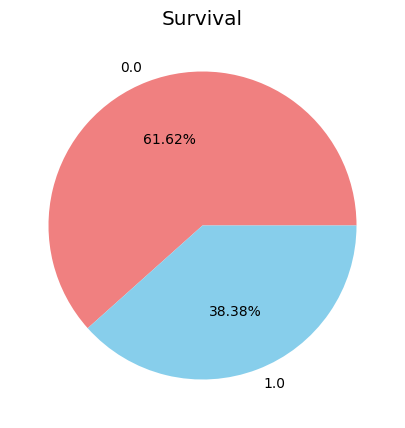

In [18]:
plt.figure( figsize=(10,5) )
df_data['Survived'].value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
plt.title( 'Survival' )  # 圖標題
plt.ylabel( '' )
plt.show()

### 相關係數(Correlation)

利用 corr( ) 函數，計算特徵欄位彼此間的相關係數，可作為後續決定篩選哪些特徵欄位，來餵入模型進行訓練。觀察 Survived 欄位與其他特徵欄位的相關係數，發覺彼此間並無明顯的線性關係。

In [21]:
# 過濾掉非數值欄位
df_numeric = df_train.select_dtypes(include=['number'])

# 計算相關係數矩陣
Corr_Matrix = df_numeric.corr()

# 取得與 'Survived' 相關的排序
Corr = Corr_Matrix.loc['Survived', :].sort_values()[:-1]

# 轉為 DataFrame
Corr = pd.DataFrame({'Survived': Corr})

# 顯示結果
Corr

,Survived
Pclass,-0.338481
Age,-0.077221
SibSp,-0.035322
PassengerId,-0.005007
Parch,0.081629
Fare,0.257307


### 生存率(Survival Rate)  

接下來，我們分別觀察性別(Sex)、票務艙(Pclass)、登船港口(Embarked)、兄弟姊妹配偶人數(SibSp)、父母子女人數(Parch)與生存率的關係。

In [24]:

# 過濾掉非數值欄位
df_numeric = df_train.select_dtypes(include=['number'])

# 計算相關係數矩陣
Corr_Matrix = df_numeric.corr()

# 取得與 'Survived' 相關的排序
Corr = Corr_Matrix.loc['Survived', :].sort_values()[:-1]

# 轉為 DataFrame
Corr = pd.DataFrame({'Survived': Corr})

# 顯示結果
print(Corr)


             Survived
Pclass      -0.338481
Age         -0.077221
SibSp       -0.035322
PassengerId -0.005007
Parch        0.081629
Fare         0.257307


In [25]:
for col in selected_cols:
    l = ['Survived']
    l.append(col)
    Survival_Rate = df_data[l].groupby(by=col).mean().round(4).reset_index()
    Survival_Rate.columns = [col,'Survival Rate(%)']
    Survival_Rate['Survival Rate(%)'] = Survival_Rate['Survival Rate(%)'].map( lambda x:x*100 )
    display( Survival_Rate )

,Sex,Survival Rate(%)
0,female,74.20
1,male,18.89


,Pclass,Survival Rate(%)
0,1,62.96
1,2,47.28
2,3,24.24


,Embarked,Survival Rate(%)
0,C,55.36
1,Q,38.96
2,S,33.70


,SibSp,Survival Rate(%)
0,0,34.54
1,1,53.59
2,2,46.43
3,3,25.00
4,4,16.67
5,5,0.00
6,8,0.00


,Parch,Survival Rate(%)
0,0,34.37
1,1,55.08
2,2,50.00
3,3,60.00
4,4,0.00
5,5,20.00
6,6,0.00
7,9,NaN


透過上列的長條圖(Bar Plot)與統計表，我們可得到下列的觀察：
* 女性的生存率明顯高於男性；  
* 票務艙($Pclass$)的生存率大小: Pclass 1 > Pclass 2 > Pclasss 3；
* 登船港口($Embarked$)的生存率以 C 最高；
* 當船上的兄弟姐妹配偶人數($SibSp$)有 1 人同行時，則生存率較高；
* 當船上的父母子女人數($Parch$)為 1~3 人時，有較高的生存率。

由於 SibSp 與 Parch 欄位所記錄的人數皆屬於家庭成員，所以我們將兩者相加創造新的特徵欄位稱家庭人數(Family_Size)，並觀察 Family_Size 與生存率的關係，發現當家庭人數為4時的生存率(約 72.4%)明顯高於其他人數。

In [26]:
# 創造新的特徵變數：家庭人數(Family_Size)
df_data['Family_Size'] = df_data['SibSp'] + df_data['Parch'] + 1

Survival_Rate = df_data[['Family_Size','Survived']].groupby(by=['Family_Size']).agg(np.mean)*100
Survival_Rate.columns = ['Survival Rate(%)']
Survival_Rate.reset_index()

,Family_Size,Survival Rate(%)
0,1,30.353818
1,2,55.279503
2,3,57.843137
3,4,72.413793
4,5,20.000000
5,6,13.636364
6,7,33.333333
7,8,0.000000
8,11,0.000000


透過上列 Family_Size 欄位與生存率的關係，我們將 Family_Size 的生存率做級別的區分(3 表示生存率最高、1 為最低)。

In [27]:
df_data[ 'Family_Class' ] = np.nan

df_data.loc[ df_data.Family_Size==0, 'Family_Class' ] = 2
df_data.loc[ (df_data.Family_Size>=1) & (df_data.Family_Size<=3), 'Family_Class' ] = 3
df_data.loc[ (df_data.Family_Size>=4) & (df_data.Family_Size<=6), 'Family_Class' ] = 2
df_data.loc[ (df_data.Family_Size>=7), 'Family_Class' ] = 1

另外，就整體而言，女性乘客的生存率(74%)明顯高於男性(19%)，此時我們想更深入探討，在不同票務艙(Pclass)中的男性及女性，生存率是否也有明顯的差別？我們發現在 Pclass 1 與 Pclass 2 中，男女的生存率差異性更是明顯！！其中，在 Pclass 1 中的女性乘客生存率更是高達約 97%。

In [28]:
# Sex & Pclass
Survival_Rate = df_data[['Sex','Pclass','Survived']].groupby(by=['Sex','Pclass']).agg(np.mean)*100
Survival_Rate.columns = ['Survival Rate(%)']
Survival_Rate.reset_index()

,Sex,Pclass,Survival Rate(%)
0,female,1,96.808511
1,female,2,92.105263
2,female,3,50.000000
3,male,1,36.885246
4,male,2,15.740741
5,male,3,13.544669


相似的手法，我們依據在不同艙等中的男女性生存率，給予不同的生存率級別(3最高、1最小)：

In [29]:
df_data[ 'Sex_Pclass' ] = np.nan
df_data.loc[ (df_data.Sex=='female') & (df_data.Pclass==1), 'Sex_Pclass' ] = 2
df_data.loc[ (df_data.Sex=='female') & (df_data.Pclass==2), 'Sex_Pclass' ] = 3
df_data.loc[ (df_data.Sex=='female') & (df_data.Pclass==3), 'Sex_Pclass' ] = 3
df_data.loc[ (df_data.Sex=='male') & (df_data.Pclass==1), 'Sex_Pclass' ] = 1
df_data.loc[ (df_data.Sex=='male') & (df_data.Pclass==2), 'Sex_Pclass' ] = 1
df_data.loc[ (df_data.Sex=='male') & (df_data.Pclass==3), 'Sex_Pclass' ] = 2

## 特徵工程(Feature Engineering)   

在分析觀察完資料後，我們接著將處理一些無法直接餵入模型的特徵欄位，例如： Name 欄位為字串、Cabin 欄位中存有大量的缺漏值等。

### (1) 字串欄位處理

#### Name (姓名)

首先，我們可先觀察 Name 欄位，發現可以擷取出稱謂(Title)的資訊，來幫助提升模型預測的準確度。一般在處理字串資料時，常用的函數有 split( )、repalce( ) 等來分割或取代字串中的文字，再比較程式語法化的方法可參考正規表示法(Regular Expression)，這裏我們分別練習兩種方法：split( ) 與正規表示法，來擷取出 Name 欄位中的稱謂，產生的結果將僅有一個不同，其他皆完全相同：

In [30]:
# Method 1: split()
df_data['Title'] = df_data.Name.str.split(', ', expand=True)[1]
df_data['Title'] = df_data.Title.str.split('.', expand=True)[0]
df_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [31]:
# Method 2: 正規表示法(Regular Expression)
import re

regex = re.compile( ' ([A-Za-z]+)\.' )
df_data['Title'] = df_data.Name.map( lambda x:regex.search(x)[0] )
# Dropping the first and the last words
df_data['Title'] = df_data.Title.map( lambda x:x[1:][:-1] )
df_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

將同樣性別或關係的稱謂合併，避免產生某些稱謂僅有少數乘客，例如：Rev(Reverend)為牧師的尊稱、Countess為伯爵夫人等，影響模型的預測準確度。這裏我們將利用 replace( ) 函數，將上述擷取出的稱謂總歸為五類：Mr、Mrs、Miss、Master、Rare。

In [32]:
df_data['Title'] = df_data.Title.replace( ['Don','Rev','Dr','Major','Lady','Sir','Col','Capt','Countess','Jonkheer','Dona'], 'Rare' )
df_data['Title'] = df_data.Title.replace( ['Ms','Mlle'], 'Miss' )
df_data['Title'] = df_data.Title.replace( 'Mme', 'Mrs' )
df_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare'], dtype=object)

In [33]:
# 刪除原始資料中的 Name 欄位
df_data.drop( 'Name', axis=1, inplace=True )

#### 船票號碼(Ticket)
另外，我們合理假設 Ticket 中，前面英文字母的部份代表房間位於相同的區域中，我們再次利用 split( ) 及 repalce( ) 函數，來擷取 Ticket 字串中前面英文字母的部份文字訊息，作為乘客艙房的位置分區。

In [34]:
df_data['Ticket_info'] = df_data.Ticket.apply( lambda x:x.replace('.','').replace('/','').strip().split(' ')[0] if not x.isdigit() else 'X')
df_data['Ticket_info'].unique()

array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

In [35]:
# 刪除原始資料中的 Ticket 欄位
df_data.drop( 'Ticket', axis=1, inplace=True )

### (2) 填補缺漏值(Missing Values)  

針對存有缺漏值的欄位：Embarked、Fare、Cabin 及 Age 進行補值。一般而言，我們常選擇用平均值(Mean)、中位數(Median)或眾數(Mode)等補值，且利用 fillna( ) 函數來執行填補的動作，另外，較為進階的做法是透過機器學習模型進行補值，如：線性迴歸模型(Linear Regression)、決策樹(Decision Tree Regressor)等。   
在補缺漏值前，我們再次查看整體資料的缺漏值分佈情況：

In [36]:
Missing_Counts( df_data.drop('Survived', axis=1) )

,ColumnName,MissingCount,Percentage(%)
0,Fare,1,0.08
1,Embarked,2,0.15
2,Age,263,20.09
3,Cabin,1014,77.46


#### 票價(Fare) : 填補整體票價的中位數

In [37]:
df_data['Fare'].fillna( df_data.Fare.median(), inplace=True )

#### 登船港口(Embarked) : 填補次數最多的港口 'S'

In [38]:
# 計算 Embarked 欄位中每個相異值的次數
display( df_data['Embarked'].value_counts() )
# 填補 Embarked 欄位的缺漏值
df_data['Embarked'].fillna( 'S', inplace=True )

,count
Embarked,
S,914
C,270
Q,123


#### 年齡(Age) :

因為 Age 欄位的缺漏值佔比約有 20% ，不像前面 Fare 及 Embarked 欄位中僅有少數不到 1% 的缺漏值，因此我們所填補缺漏的值可能會影響預測的結果。此時，我們先藉由 Age 搭配 Sex 或 Pclass 欄位，觀察缺漏值分布的情況，檢視缺漏值是否集中發生在某類特別的乘客當中？

In [39]:
# 新增標註 Age 欄位是否為缺漏值的欄位(有缺漏標為0)
df_data['isAge'] = df_data['Age'].isnull().map( lambda x:0 if x==True else 1 )

In [1]:
# 分別觀察 Age 與 Sex、Pclass 的缺漏值分布狀況
display( pd.crosstab( df_data.isAge, df_data.Sex, margins=True ) )
display( pd.crosstab( df_data.isAge, df_data.Pclass, margins=True ) )

NameError: name 'pd' is not defined

ValueError: The following variable cannot be assigned with wide-form data: `hue`

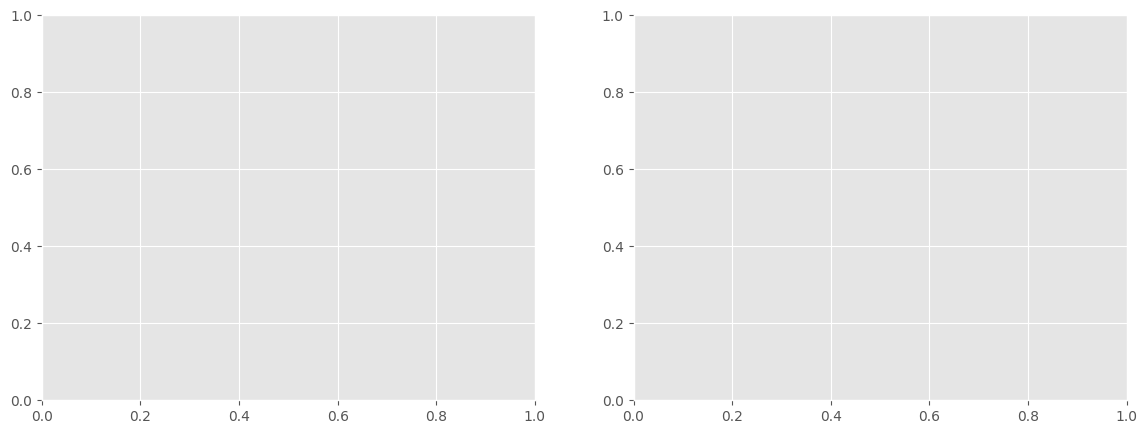

In [42]:
fig, axs = plt.subplots(1,2,figsize=(14,5))
#plt.suptitle('Age')

plt.subplot(1,2,1)
sns.countplot( df_data.Sex, hue=df_data.isAge, palette=['lightcoral','skyblue'] )
plt.ylabel( 'Counts' )

plt.subplot(1,2,2)
sns.countplot( df_data.Pclass, hue=df_data.isAge, palette=['lightcoral','skyblue'] )
plt.ylabel( '' )

plt.show()

經觀察上表及圖後可知，Age 欄位的缺漏值明顯分佈在 Pclass 3 中，約佔 29.34%(=208/709)，進一步觀察在 Pclass 1 及 Pclass 2 的乘客中，Age 欄位對於存活率是否有明顯的影響？

In [ ]:
index_S = (df_data.isAge==1)&(df_data.Pclass!=3)&(df_data.Survived==1)
index_D = (df_data.isAge==1)&(df_data.Pclass!=3)&(df_data.Survived==0)

plt.figure( figsize=(14,5) )
sns.distplot( df_data.loc[index_S,'Age'], bins=20, color='blue', label='Survived' )
sns.distplot( df_data.loc[index_D,'Age'], bins=20, color='red', label='Dead' )
plt.title( 'Pclass = 1 or 2' )
plt.legend( )
plt.show( )

從上圖可觀察到，在 Pclass 1 及 Pclass 2 的乘客中，年齡約小於 17 歲的乘客中有明顯較高的生存率，若年齡超過 17 歲則生存率並無明顯的差別，所以我們可大膽假設 Age 欄位與生存率具有關聯性，另外，因為年齡與稱謂(Title)也有相當程度的關聯，因此，我們將先計算每個稱謂的年齡平均值，再用此平均值來填補每個 Title 中所對應 Age 欄位的缺漏值。

In [ ]:
# 計算每個 Title 的年齡平均值及中位數
Age_Mean = df_data[['Title','Age']].groupby( by=['Title'] ).mean()
Age_Median = df_data[['Title','Age']].groupby( by=['Title'] ).median()

Age_Mean.columns = ['Age Mean']
Age_Median.columns = ['Age Median']
Age_Mean.reset_index( inplace=True )
Age_Median.reset_index( inplace=True )

display( Age_Median )
display( Age_Mean )

In [ ]:
# 利用每個 Title 的年齡平均數，填補每個 Title 所對應 Age 的缺漏值
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Master'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Master','Age Mean'][0]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Miss'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Miss','Age Mean'][1]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Mr'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Mr','Age Mean'][2]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Mrs'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Mrs','Age Mean'][3]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Rare'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Rare','Age Mean'][4]

# 刪除 isAge 欄位
df_data.drop( 'isAge', axis=1, inplace=True )

填滿 Age 欄位的缺漏值後，我們將年齡特徵再區分成未滿17歲及17歲以上，未滿17歲的乘客標為1，17歲以上的乘客標為0。

In [ ]:
# 乘客年齡是否未滿17歲(是：1；否：0)
df_data[ 'is_Age_17' ] = (df_data.Age<17)*1
df_data

#### 船艙號碼(Cabin) :

因爲整體 Cabin 欄位約有 77% 的缺漏值，我們在觀察 Cabin 欄位中的資料類別後，僅取出頭一個英文字母作為分類的標籤，其他缺漏的欄位以 NoCabin 表示。

In [ ]:
# 觀察 Cabin 中的種類
df_data['Cabin'].unique()

In [ ]:
# 取出 Cabin 中的第一個字母，如果為缺漏值，則以 NoCabin 表示
df_data['Cabin'] = df_data['Cabin'].apply( lambda x:str(x)[0] if not pd.isnull(x) else 'NoCabin' )
df_data['Cabin'].unique()

最後，在完成上述缺漏值的填補後，我們再次檢查是否還有缺漏值尚未填補到。

In [ ]:
Missing_Counts( df_data.drop('Survived', axis=1) )

### (3) 離群值(Outlier)   

因為離群值會明顯影響非樹狀模型的預測結果，例如：線性迴歸(Linear Regression)模型，因此，針對連續型的數值欄位，我們還需再檢視其資料的分布情況，透過觀察直方圖(Histogram)或盒鬚圖(Box Plot)，可用來判斷欄位是否有離群值。   

Reference :    
(1) [Understanding Boxplots](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51)

#### 乘客票價(Fare) :   

首先，我們先觀察 Fare 欄位的直方圖(Histogram)及盒鬚圖(Box Plot)資料分布狀況：  

In [ ]:
# 對 Fare 欄位取對數
df_data['LogFare'] = np.log1p( df_data.Fare )

# 直方圖(Histogram)
fig, axs = plt.subplots( 1,2,figsize=(12,5) )

plt.subplot( 1,2,1 )
sns.distplot( df_data.Fare, kde=True, bins=45, color='skyblue', label='bins = 45' )
plt.xlabel( 'Fare' )
plt.ylabel( 'Counts' )
plt.legend( )

plt.subplot( 1,2,2 )
sns.distplot( df_data.LogFare, kde=True, bins=45, color='skyblue', label='bins = 45' )
plt.xlabel( 'Log Fare' )
plt.ylabel( '' )
plt.legend( )

plt.show()

In [ ]:
# 盒鬚圖(Box Plot)
fig, axs = plt.subplots( 1,2,figsize=(12,5) )

plt.subplot( 1,2,1 )
sns.boxplot( df_data.Fare, orient='h', color='skyblue' )
plt.xlabel( 'Fare' )

plt.subplot( 1,2,2 )
sns.boxplot( df_data.LogFare, orient='h', color='skyblue' )
plt.xlabel( 'Log Fare' )

plt.show()

從上面直方圖及盒鬚圖可知，初步判斷 Fare 欄位可能存有離群值( i.e., 大於 Q3+1.5$\times$IQR )。計算 Fare 欄位的四分位數(Quartile)，且以四分位數對 Fare 欄位進行分組，觀察生存率是否會因票價組別的高低有所差異？藉此判斷票價大於 Q3+1.5$\times$IQR 是否可視為離群值。

In [ ]:
# 計算 Fare 欄位各個百分位數(Percentile)
P_all = [ np.percentile( df_data.Fare, q=i ) for i in np.arange(0,101) ]
Pth_Percentile = pd.DataFrame( { 'Q':list(range(101)), 'Value':P_all } )

# The first、second and third quartile(i,e., the 25th、50th and 75th Percentile)
Q1 = Pth_Percentile.iloc[ 25, 1 ]
Q2 = Pth_Percentile.iloc[ 50, 1 ]
Q3 = Pth_Percentile.iloc[ 75, 1 ]
IQR = Q3 - Q1

print( f'Q1 = {Q1}' )
print( f'Q2 = {Q2} = Median' )
print( f'Q3 = {Q3}' )
print( f'Maximum = {df_data.Fare.max()}')
print( f'IQR = Q3 - Q1 = {IQR}' )
print( f'Q3 + 1.5IQR = {Q3+1.5*IQR}' )

# 依照四分位數，對 Fare 欄位進行分組
Fare_bin = [ 0, Q1, Q2, Q3, Q3+1.5*IQR, df_data.Fare.max() ]
df_data[ 'Fare_Group' ] = pd.cut( df_data.Fare.values, Fare_bin )

# 計算每個分組中的資料筆數
Group_Counts = df_data[ 'Fare_Group' ].value_counts().reset_index()
Group_Counts.columns = [ 'Fare_Group', 'Counts' ]
Group_Counts.sort_values( by='Fare_Group' )

再次藉由長條圖及盒鬚圖，觀察不同的票價組別，彼此間生存率的差異性。

In [ ]:
plt.subplots( figsize=(12,5) )
sns.countplot( df_data.Fare_Group, hue=df_data.Survived, palette=['lightcoral','skyblue'] )
plt.ylabel( 'Counts' )
plt.xticks( rotation=-45, fontsize=12 )
plt.show()

In [ ]:
plt.subplots( figsize=(15,12) )
sns.boxplot( x='LogFare', y='Fare_Group', data=df_data, hue='Survived', orient='h', color='skyblue' )
plt.yticks( rotation=-30, fontsize=15 )
plt.show()

從上圖可明顯觀察出，票價組別越高生存率相對越大，且每一票價組別中，生還者的票價中位數皆高於罹難者的票價中位數；所以，我們可大膽推測 Fare 與生存率有相關性，Fare 越高生存機率越大，且對 Fare 欄位僅做對數轉換並不做離群值的處理。

In [ ]:
# 刪除 Fare_Group 欄位
df_data.drop( ['Fare','Fare_Group'], axis=1, inplace=True )

### (4) 獨熱編碼(OneHot Encoding)、標籤編碼(Label Encoding)  

對於定性且無序的特徵欄位，例如：性別、顏色、國家別等，我們可利用 get_dummies( ) 函數執行獨熱編碼，將其轉換成定量資料，這裏我們對 Embarked 欄位做獨熱編碼；另外，因為女性的生存率明顯高於男性，故我們對 Sex 欄位做標籤編碼。

#### 登船港口(Embarked) :  

In [ ]:
# OneHot Encoding
OneHot_Embarked = pd.get_dummies( df_data.Embarked, prefix='Embarked' )

# 合併 Embarked 編碼後的欄位
df_data = pd.concat( [ df_data, OneHot_Embarked ], axis=1 )
df_data.drop( 'Embarked', axis=1, inplace=True )

#### 性別(Sex) :  

In [ ]:
# Label Encoding
Sex_mapping = { 'male':0, 'female':1 }
df_data[ 'Sex' ] = df_data.Sex.map( Sex_mapping )

## 訓練集(Train)與測試集(Test)

在完成前述的資料分析及特徵工程後，我們就快可以把資料餵入模型進行訓練了！在此之前的最後一個注意步驟，就是需確認每個欄位皆為數值型態，且將資料分割回訓練集(train)與測試集(test)。所以，此時我們先檢視特徵工程後的資料，觀察是否還有需要處理的欄位：

In [ ]:
# 檢視特徵工程後的資料
print( f'Shape of data after feature engineering = {df_data.shape}' )
df_data.head()

### (1) 類別型態欄位轉為整數  

檢視後發現，因為我們之前有處理過字串欄位，所以資料中還存有 4 欄類別型態的欄位：Cabin、Embarked、Title、Ticket_info，因此，我們也需要將它們轉換成數值型態欄位：

In [ ]:
for col in ['Title','Ticket_info','Cabin']:
    df_data[col] = df_data[col].astype('category').cat.codes

df_data.head()

### (2) 產生訓練集(Train)與測試集(Test)   

最後，我們將整體資料分割回訓練集與測試集兩部份，訓練集用來餵入模型進行訓練，測試集則為模型最終要預測的結果，此外，在分割產出資料後，我們刪除與生存率無毫關聯性的欄位 PassengerId。

In [ ]:
# 產生訓練集和測試集
Train = df_data[ pd.notnull(df_data.Survived) ]
Test = df_data[ pd.isnull(df_data.Survived) ]

# 訓練集刪除 PassengerId 欄位；
# 測試集刪除 PassengerId 與 Survived 欄位
Train.drop( ['PassengerId'], axis=1, inplace=True )
Test.drop( ['PassengerId','Survived'], axis=1, inplace=True )

# 將測試集中的標籤欄位 Survived 單獨拆出
Y_Train = Train.Survived
X_Train = Train.drop( ['Survived'], axis=1 )

print( f'Shape of X_Train = {X_Train.shape}' )
print( f'Shape of Y_Train = {Y_Train.shape}' )
print( f'Shape of Test = {Test.shape}' )

## 特徵重要性(Feature Importance)

我們使用最基本的樹狀模型 - 決策樹(Decision Tree)，來評估特徵欄位對於標籤欄位(Survived)的重要性，目的是幫助我們篩選較具關鍵性的特徵欄位，提升模型的預測能力。評估特徵重要性的方法並非僅侷限於決策樹，另外其他常見的手法有：相關係數(Correlation)、Lasso等。

In [ ]:
# 建立決策樹模型
DTC = RandomForestClassifier( )
# 自變數、應變數進行擬合
DTC.fit( X_Train, Y_Train )

# 排序特徵重要性(由大到小)
col_names = X_Train.columns
importances = DTC.feature_importances_
Feature_Rank = pd.DataFrame( { 'Feature_Name':col_names, 'Importance':importances } )
Feature_Rank.sort_values( by='Importance', ascending=False, inplace=True )
Feature_Rank

## 建立模型  

在完成評估特徵重要性後，我們選擇使用隨機森林(Random Forest)來預測資料。由於在森林中每一棵樹的生成方法為拔靴法(Boostrap)，表示每一棵樹並不會用到所有的訓練集資料來生成，而未使用的樣本稱為袋外樣本(Out of Bag Sample)，其可用來評估預測的準確度，每一顆樹皆以這種方式生成，最後對所有樹的準確度取平均值，這便是隨機森林的特性。   

Reference:   
[RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [ ]:
# 隨機森林參數：
# n_estimators: 樹的數量(default=10)。
# min_samples_leaf: 最終葉節點最少樣本數(default=1)；
#                   當樣本不大時，可不設定使用預設，若樣本數量非常大時，則推薦增加此參數值。
# min_samples_split:節點再劃分時所需的最小樣本數(default=2)；
#                   當樣本不大時，可不設定使用預設，若樣本數量非常大時，則推薦增加此參數值。
# oob_score: 是否採用袋外樣本(out-of-bag samples)來評估模型的準確度(default=False)。

RFC = RandomForestClassifier( n_estimators = 1000,
                              min_samples_split = 20,
                              min_samples_leaf = 1,
                              oob_score = True,
                              random_state = 1,
                              n_jobs = -1 )

## 訓練模型

餵入訓練集資料(X_Train,Y_Train)訓練隨機森林(Random Forest)模型。一般而言，為了衡量模型的預測能力，在訓練模型之前，我們還會從訓練集中抽取出一小部份作為驗證集(Validation)，用來評估模型的準確度，而剩下沒被抽取到的資料則用來訓練模型，另外，為避免只參考某一特定的抽樣驗證結果，導致模型產生偏差，我們會藉由交叉驗證(Cross Validation)，來評估模型的準確度是否能達到我們要求的水準。   
因為隨機森林可藉由前述所提的袋外樣本評估準確度，因此這裏我們便不需進行交叉驗證；然而，我們還想知道特徵欄位的多寡對於模型準確度的影響，所以，先把所有的欄位餵入模型進行訓練：  

In [ ]:
# 訓練模型
RFC.fit( X_Train, Y_Train )
print( 'oob_score = {:.6f}'.format(RFC.oob_score_) )

將所有的特徵欄位餵入模型進行訓練，訓練完成的模型準確率約 83.3%；接下來，我們試著參考上述特徵重要性的結果，只選擇部份特徵欄位來訓練模型，觀察這樣的模型準確度是否能有所提升？

In [ ]:
RFC_2 = RandomForestClassifier( n_estimators = 1000,
                                min_samples_split = 20,
                                min_samples_leaf = 1,
                                oob_score = True,
                                random_state = 1,
                                n_jobs = -1 )

# 篩選部份特徵欄位餵入模型進行訓練
SelectedFeatures = ['Age','Sex','LogFare','Title','Pclass','Sex_Pclass']
RFC_2.fit( X_Train[SelectedFeatures], Y_Train )

print( f'Selected Features :\n   {SelectedFeatures}' )
print( 'oob_score = {:.6f}'.format(RFC_2.oob_score_) )

經觀察，只篩選部份特徵欄位所訓練出的模型準確率約 84.4%，略高於所有特徵欄位所訓練出的模型，從這我們可得到一個寶貴的經驗，就是適當的挑選出關鍵性的特徵欄位進行訓練，對於模型的準確度將會有所提升。

## 測試集預測

最後，將我們訓練完成的模型用來預測測試集資料，且上傳預測結果至 Kaggle，終於大公告成了！！

In [ ]:
# 預測測試集資料
Test_pred = RFC_2.predict( Test[SelectedFeatures] )

# 檢視預測罹難或生還的機率
#print( RFC_2.predict_proba(Test[SelectedFeatures]) )

# 提交檔案
submit['Survived'] = Test_pred.astype(int)
submit.to_csv( 'Titanic_RandomForest.csv', index=False )
print( f'預測結果：' )
submit

## 總結  

藉由 Kaggle 上鐵達尼號生存預測比賽，我們簡單地分享有關資料的分析及處理技巧，除希望文中的程式碼範本能幫助初心者們快速上手外，更希望能使讀者瞭解一個機器學習專案的基本構思及流程，通常一個機器學習專案，我們會耗費絕大部分的時間在資料分析與特徵工程上，模型的選用及調整參數是不太需要花時間的。因此，一個專案要能順利進行，除需具備熟練的程式語言外，該領域的專業知識及實務經驗，更是一大關鍵的因素。   
最後，對於鐵達尼號生存預測比賽有興趣的初心者們，不妨再試著做更多不同的觀察及嘗試，相信你將會獲得多元的收穫與經驗！針對本文的內容，若讀者們有發現任何的錯誤或疑問，非常歡迎您來信給予建議及討論，讓我們一同來學習成長！